In [13]:
data_dir='KMC_LiverGrading\Training'
data_dir1='KMC_LiverGrading\Test'
data_dir2='KMC_LiverGrading\Validation'
import os

In [14]:
os.listdir(data_dir)

['grade0', 'grade1', 'grade2', 'grade3']

In [17]:
from torchvision.datasets import ImageFolder
train_dataset=ImageFolder(data_dir)
test_dataset=ImageFolder(data_dir1)
val_dataset=ImageFolder(data_dir2)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

2549
280
280


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

2


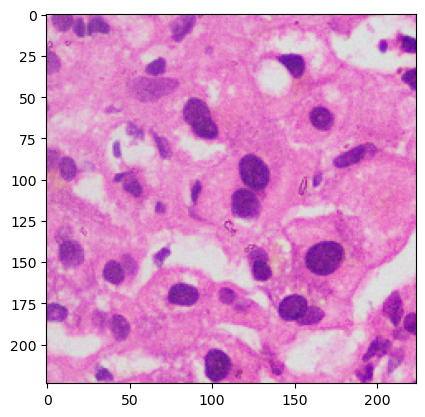

In [19]:
img,label=train_dataset[1318]
plt.imshow(img)
print(label)

In [30]:
import torchvision.transforms as tt
dataset=ImageFolder(data_dir,tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

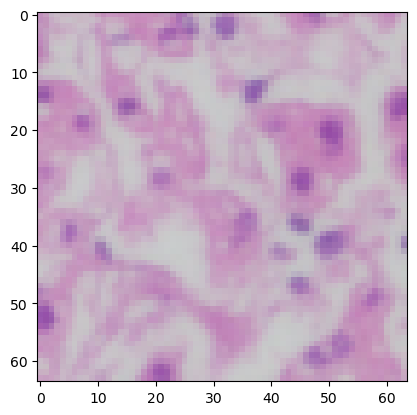

In [31]:
img,label=dataset[100]
plt.imshow(img.permute(1,2,0))

In [32]:
batch_size=128
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(val_dataset,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

In [33]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [34]:
train_dataset[1900]

(<PIL.Image.Image image mode=RGB size=224x224>, 3)

In [36]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
torch.cuda.is_available()


False

In [38]:
device = get_default_device()

In [39]:
device


device(type='cpu')

In [40]:
img

tensor([[[0.7569, 0.7725, 0.7725,  ..., 0.7569, 0.7686, 0.7882],
         [0.7490, 0.7569, 0.7765,  ..., 0.7608, 0.7804, 0.7882],
         [0.7608, 0.7569, 0.7843,  ..., 0.7804, 0.7882, 0.7725],
         ...,
         [0.7843, 0.7843, 0.7725,  ..., 0.7686, 0.7647, 0.7765],
         [0.7882, 0.7882, 0.7843,  ..., 0.7529, 0.7529, 0.7843],
         [0.7843, 0.7765, 0.7882,  ..., 0.7686, 0.7647, 0.7765]],

        [[0.5686, 0.6157, 0.7059,  ..., 0.5412, 0.6275, 0.7216],
         [0.5608, 0.5804, 0.6706,  ..., 0.5725, 0.6706, 0.7490],
         [0.5922, 0.5843, 0.6549,  ..., 0.6314, 0.7255, 0.7647],
         ...,
         [0.7412, 0.7333, 0.6353,  ..., 0.5451, 0.5882, 0.7098],
         [0.6902, 0.6941, 0.6392,  ..., 0.5647, 0.5647, 0.6627],
         [0.6314, 0.6235, 0.6392,  ..., 0.6039, 0.5843, 0.6549]],

        [[0.7412, 0.7490, 0.7765,  ..., 0.7373, 0.7529, 0.7843],
         [0.7373, 0.7333, 0.7686,  ..., 0.7294, 0.7608, 0.7843],
         [0.7451, 0.7294, 0.7725,  ..., 0.7490, 0.7804, 0.

In [41]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [42]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\USER\anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>
